In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow as tf
import json
import zipfile
import shutil

from PIL import Image
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
TRAIN_DATASET_DIR = './lab5/DogsVsCats/train/train/'

In [3]:
filenames = os.listdir(TRAIN_DATASET_DIR)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [5]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


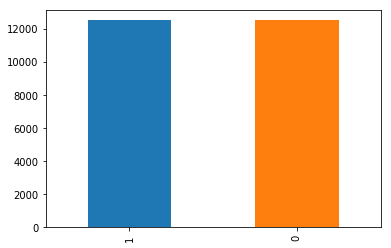

In [6]:
df['category'].value_counts().plot.bar()

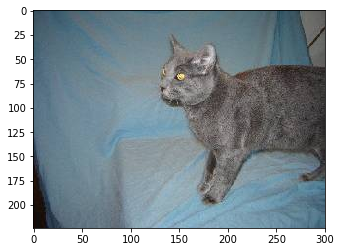

In [7]:
sample = random.choice(filenames)
image = load_img(TRAIN_DATASET_DIR+sample)
plt.imshow(image)

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150,150,3), #reshape images to 150 by 150 by 3 channels
                                include_top = False,       #get straight to the CNN layer
                                weights = 'imagenet')      #use the builed-in weight pre-trained on imagent

#замораживаем все слои предобученной модели
for layer in pre_trained_model.layers:
  layer.trainable = False

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [10]:
# #определим точность, сигнализирующую об остановке обучения
# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('acc')>0.87):
#       print("\nReached 87% accuracy. Stop training")
#       self.model.stop_training = True

Добавляем слои, после выбранного ранее слоя (mixed7). Добавленные ниже слои будут обучены.
Слои же, добавленные перед выбранным слоем не обучаются (замороженные слои). Таким образом работает передаточное обучение.
Чем больше данных нужно обучить, тем больше обучаемых слоев должно быть добавлено для обучения.

In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras import layers

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for binary classification
x = layers.Dense(2, activation='sigmoid')(x)           

# instantiate a new model 
model = Model(pre_trained_model.input, x) 

# Compile a model
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy',  
              metrics = ['acc']) 

# See the summary of the model 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
earlystop = EarlyStopping(patience=10)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

In [15]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

Train dataset is 20000 samples.
Validate dataset is 5000 samples.

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

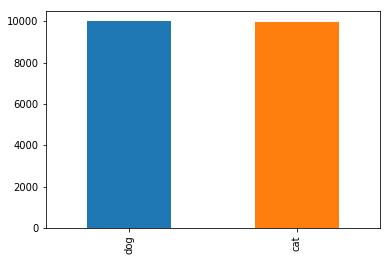

In [17]:
train_df['category'].value_counts().plot.bar()

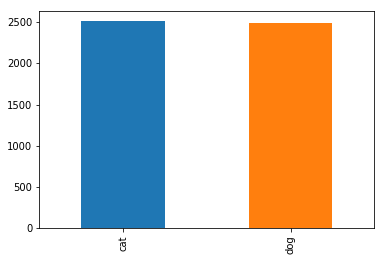

In [18]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Генерируем батчи тензора для использования дополнения данных (data augmentation).
Data augmentation is a technique to artifically create training data. It rotates, shifts, zooms, shears, or horizontally flips the training images. In keras ImageDataGenerator class, the original images are unchaged. It just implements data augmentation when they are feeded into the training/fitting.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,        #Int. Degree range for random rotations
    rescale=1./255,           #Rescaling factor. Multiply the data by the value provided (after applying all other transformations)    
    shear_range=0.2,          #Shear Intensity (Shear angle in counter-clockwise direction in degrees)  
    zoom_range=0.2,           #Range for random zoom
    horizontal_flip=True,     #Randomly flip inputs horizontally
    width_shift_range=0.2,    #Indicates the percentage of the width of the image to shift
    height_shift_range=0.2    ##Indicates the percentage of the height of the image to shift
)

#Takes the dataframe and the path to a directory and generates batches of augmented/normalized data
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./lab5/DogsVsCats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical', #2D numpy array of one-hot encoded labels
    batch_size=batch_size     #15
)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./lab5/DogsVsCats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./lab5/DogsVsCats/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


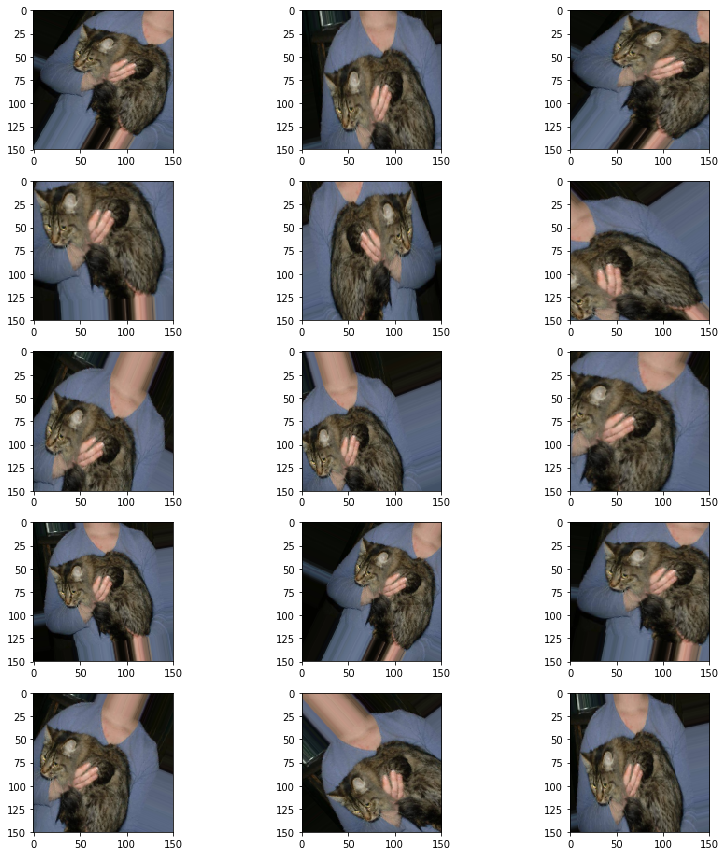

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [ ]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
epochs=5

history = model.fit_generator(
    generator = train_generator,               #feed the training data via the generator
    steps_per_epoch = total_train//batch_size, #this is the batch size. parameters are updated per this batch size
    epochs = epochs,                           #number of cycles. In one epoch, the whole dataset is used once.
   # verbose = 2,                               #print out the logs
    callbacks = callbacks,                     
    validation_data = validation_generator,    #feed the validation data via the generator
    validation_steps = total_validate//batch_size
)

Epoch 1/5
 546/1333 [===========>..................] - ETA: 1:21:38 - loss: 0.4245 - acc: 0.8144

In [ ]:
model.save_weights("model.h5")

In [ ]:
# Plot the accuracy history 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
plt.title('Training and validation loss')

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.title('Training and validation accuracy')
plt.tight_layout()
plt.show()

In [ ]:
test_filenames = os.listdir("./lab5/DogsVsCats/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./lab5/DogsVsCats/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [ ]:
test_df['category'].value_counts().plot.bar()

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./lab5/DogsVsCats/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)